In [1]:
import numpy as np
import random
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt
import pdb
import sys

sys.path.insert(0, "C:\\Users\\utabo\\Documents\\GitHub\\BootCamp2019\\ProblemSets\\ECON\\Week 5")
import parameters as p

In [2]:
#Calculate transitions:
ee=0.95
eu=1-ee
uss=0.05
uu=(uss-(1-uss)*(eu))/uss
ue=1-uu
print(ue)
p.pi=np.array([[ee,eu],[ue,uu]])
p.pi=np.array([[0.95,0.05],[0.95,0.05]])

0.9500000000000008


In [44]:
def markovsim():
    eps=np.empty([p.numsim])
    eps[0]=0
    for x in range(p.numsim-1):
        ep=np.int_(eps[x])
        eps[x+1]= np.random.uniform(0,1) <= p.pi[ep,1]
    return eps

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [8]:

#====================================================#
#Problem set - Tony Smith
#====================================================#

#Get interest rate
def get_r(kbar,u,p):
    r=p.alpha*kbar**(p.alpha-1)*(1-u)**(1-p.alpha)
    return r

#get wage rate
def get_k(kbar,u,p):
    w=(1-p.alpha)*kbar**p.alpha*(1-u)**(-p.alpha)
    return w

#euler equation:
def utility(x):
    if x>0:
        utils=np.log(x)
    else:
        utils=-(10**8)
    return utils


def negV(kprime,Vcont,eps,p,tt,r,w,kk) :
    Vprime=np.empty([2])
    #Vprime[0,0]=np.interp(p.kgrid,Vcont[:,0], kprime) #good
    if tt>0:
        #pdb.set_trace()
        Vprime[0]=np.interp( kprime,p.kgrid,Vcont[:,0]) #good
        Vprime[1]=np.interp(kprime,p.kgrid,Vcont[:,1])#bad 
        #Vprime[0]=intpl.interp1d( kprime,p.kgrid,Vcont[:,0], kind='cubic',fill_value='extrapolate') #good
        #Vprime[1]=intpl.interp1d(kprime,p.kgrid,Vcont[:,1], kind='cubic',fill_value='extrapolate')#bad 
    else:
        Vprime=np.array([0][0])
    c=(1+r-p.delta)*kk+w*eps-kprime
    EV=sum(Vprime*p.pi[eps,:]) #expected value given transition probs
#     print(Vprime.shape)
#     print(p.pi.shape)
#     print(EV.shape)
    
    value=-1*(utility(c)+p.beta*EV) #negative value of choosing kprime
    return value

#Problem that the consumer solves given kbar:
def vfi(kbar,p):
    Vcont=np.zeros([p.numptsk,2])
    pf=np.empty([p.numptsk, 2])
    vopt=np.empty([p.numptsk, 2])
    r=get_r(kbar,u,p)
    w=get_k(kbar,u,p)
    for tt in range(0,p.maxiter):
        for ixe, eps in enumerate(p.epsgrid):
            for ixk, kk in enumerate(p.kgrid):
                #res= opt.minimize_scalar(negV,bracket=(0.00001,1),args=(Vcont,eps,p,tt,r,w,kk), method='Golden' )          
                res= opt.minimize_scalar(negV,bounds=(0.001, 40),args=(Vcont,eps,p,tt,r,w,kk), method='bounded' )
                vopt[ixk,ixe] =-res.fun
                pf[ixk,ixe] =res.x
        diff=((vopt-Vcont) ** 2).sum()        
        if diff>p.tol:
            Vcont=vopt
        else:
            print("convergence 1 achieved")
            #print(pf)
            #pdb.set_trace()
            epsseries=np.zeros(p.numsim)
            indk=np.zeros(p.numsim)
            #once we found a solution we want to simulate:
            np.random.seed(56758)
            rv=np.random.uniform(0,1,p.numsim)
            epsseries[rv<0.95]=1.0
            
            #print(epsseries)
            epsseries=np.int_(epsseries)
            #epsseries=epsseries.astype(int)
            #for x in range(p.numsim):
            #    epsseries[x]=random.randint(0,1)
            indk[0]=30
            for ixN, epsilon in enumerate(epsseries):
                indk[ixN]=np.interp(indk[ixN-1],p.kgrid, pf[:,epsilon])
                #indk[ixN]=intpl.interp1d(indk[ixN-1],p.kgrid, pf[:,epsilon], kind='cubic',fill_value='extrapolate')
                
                #indk[ixN]=np.interp(p.kgrid, pf[:,epsilon],kss)
            kss=np.mean(indk)
            break
    return vopt, pf,kss,indk


def aiyagari(kbar,p):
    for j in range(0,p.maxiter):
        print("outer loop:")
        print(j)
        vopt, pf,kss,indk=vfi(kbar,p)
        print(abs(kss-kbar))
        if abs(kss-kbar)>p.tol_outer:
            
            kbar=kss
            
        else:
            print("convergence 2 achieved")
            break
    return vopt, pf,kss,indk

#
# define k grid

u=0.1
#initialize Vcont

vopt_out, pf_out,kss_out,indk=aiyagari(30,p)
print(kss_out)
print(np.std(indk)/np.mean(indk))

outer loop:
0
convergence 1 achieved
9.891192662038776
outer loop:
1
convergence 1 achieved
0.2809042883169397
outer loop:
2
convergence 1 achieved
0.18933653803954087
outer loop:
3
convergence 1 achieved
0.07149701059813651
outer loop:
4
convergence 1 achieved
0.0004827106794564884
outer loop:
5
convergence 1 achieved
2.1141419921377747e-06
convergence 2 achieved
39.72764307634179
0.015512607899817656


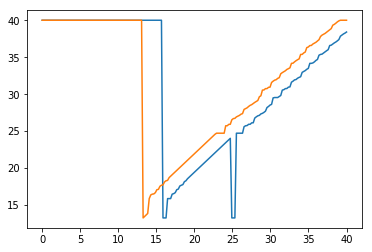

In [10]:
plt.plot(p.kgrid,pf_out[:,0])
plt.plot(p.kgrid,pf_out[:,1])
plt.show()

array([39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99999571,
       39.99999571, 39.99999571, 39.99999571, 39.99999571, 39.99

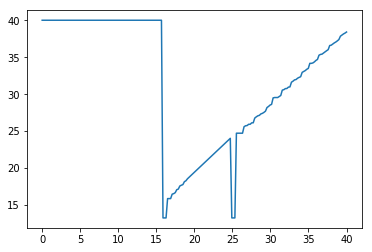

In [5]:
plt.plot(p.kgrid,pf_out[:,0])
pf_out[:,0]

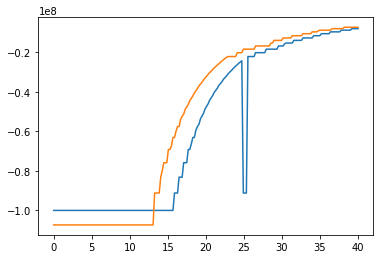

In [6]:
plt.plot(p.kgrid,vopt_out[:,0])
plt.plot(p.kgrid,vopt_out[:,1])
plt.show()